In [129]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

## 1.0: General Overview of the Dataset and its Features

In [130]:
df = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

### 1.1: First few observations and the dataframe's shape

In [131]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [132]:
df.shape

(1460, 81)

We have 1460 observations in the training dataset and 81 features. 

### 1.2: What about missing values? How many are there? Where are they concentrated?

In [133]:
df.isna().sum().sum()

6965

In [134]:
df.isna().sum().sort_values(ascending = False).head(15)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
dtype: int64

There seems to be about 6965 missing values focused on optional additions to a house like pools, fences, firplaces, garages, basements, and miscellaneous features. 

### 1.3: Breakdown Of Predictive Features

In [135]:
## Splitting the features of the dataset into distinct classes
noms = ['MSSubClass','MSZoning', 'Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

ords = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

continuous = ['LotFrontage','MasVnrArea']

discrete = ['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','OverallQual','OverallCond','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars', 'YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

## Leftover features not included in the prior categories (consists of Id and SalePrice)
rest = [item for item in list(df.columns) if item not in list(noms + ords + continuous + discrete)]

An example of each of the different variable types (nominal, ordinal, discrete, and continuous) found within the dataset:

In [136]:
df[['Neighborhood','ExterQual','LotFrontage','LotArea']].head()

Neighborhood ExterQual  LotFrontage  LotArea
0      CollgCr        Gd         65.0     8450
1      Veenker        TA         80.0     9600
2      CollgCr        Gd         68.0    11250
3      Crawfor        TA         60.0     9550
4      NoRidge        Gd         84.0    14260

We have different labels, shown by the Neighborhood feature, several ranking systems, and numerical measurements of different fixtures within the house (both as floats and as integers). Of the four types of features, which are most prominent?

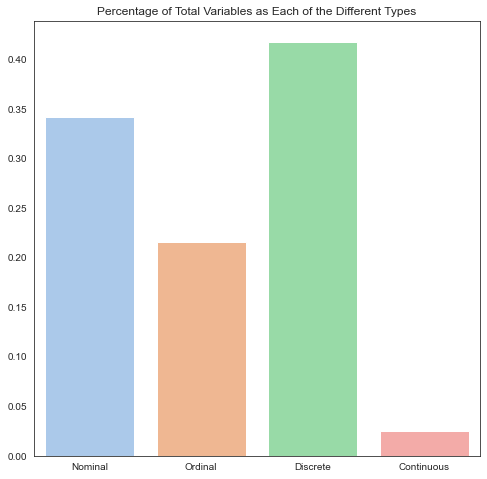

In [137]:
total = len(noms + ords + continuous + discrete)
plt.figure(figsize=(8,8))
sns.barplot(['Nominal','Ordinal','Discrete','Continuous'], [(len(noms) / total), (len(ords)/total),(len(discrete)/total),(len(continuous)/total)])
plt.title("Percentage of Total Variables as Each of the Different Types");


In [138]:
df[['Neighborhood','ExterQual','LotFrontage','LotArea']].dtypes

Neighborhood     object
ExterQual        object
LotFrontage     float64
LotArea           int64
dtype: object

The majority of features are categorical; these often need to be converted into a more descriptive datatype (turning the general object into a date or numerical value) during the cleaning phase. Of course, the discrete variables are represented by integers, and those continuous utilize float values.

### 1.4: Statistical Summary of the Numerical Variables

In [139]:
df[discrete + continuous].describe()

LotArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  \
count    1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    10516.828082   443.639726    46.549315   567.240411  1057.429452   
std      9981.264932   456.098091   161.319273   441.866955   438.705324   
min      1300.000000     0.000000     0.000000     0.000000     0.000000   
25%      7553.500000     0.000000     0.000000   223.000000   795.750000   
50%      9478.500000   383.500000     0.000000   477.500000   991.500000   
75%     11601.500000   712.250000     0.000000   808.000000  1298.250000   
max    215245.000000  5644.000000  1474.000000  2336.000000  6110.000000   

          1stFlrSF     2ndFlrSF    GrLivArea   GarageArea   WoodDeckSF  ...  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1162.626712   346.992466  1515.463699   472.980137    94.244521  ...   
std     386.587738   436.528436   525.480383   213.804841   125.338794  ...   
min     334.000000     0.000000   334.000000     0.000000     0.000000  ...   
25%     882.000000     0.000000  1129.500000   334.500000     0.000000  ...   
50%    1087.000000     0.000000  1464.000000   480.000000     0.000000  ...   
75%    1391.250000   728.000000  1776.750000   576.000000   168.000000  ...   
max    4692.000000  2065.000000  5642.000000  1418.000000   857.000000  ...   

       TotRmsAbvGrd   Fireplaces   GarageCars    YearBuilt  YearRemodAdd  \
count   1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean       6.517808     0.613014     1.767123  1971.267808   1984.865753   
std        1.625393     0.644666     0.747315    30.202904     20.645407   
min        2.000000     0.000000     0.000000  1872.000000   1950.000000   
25%        5.000000     0.000000     1.000000  1954.000000   1967.000000   
50%        6.000000     1.000000     2.000000  1973.000000   1994.000000   
75%        7.000000     1.000000     2.000000  2000.000000   2004.000000   
max       14.000000     3.000000     4.000000  2010.000000   2010.000000   

       GarageYrBlt       MoSold       YrSold  LotFrontage   MasVnrArea  
count  1379.000000  1460.000000  1460.000000  1201.000000  1452.000000  
mean   1978.506164     6.321918  2007.815753    70.049958   103.685262  
std      24.689725     2.703626     1.328095    24.284752   181.066207  
min    1900.000000     1.000000  2006.000000    21.000000     0.000000  
25%    1961.000000     5.000000  2007.000000    59.000000     0.000000  
50%    1980.000000     6.000000  2008.000000    69.000000     0.000000  
75%    2002.000000     8.000000  2009.000000    80.000000   166.000000  
max    2010.000000    12.000000  2010.000000   313.000000  1600.000000  

[8 rows x 35 columns]

Although there is much to take in here, there are important aspects of this dataset to note. First, many features represent optional housing fixtures, which many observations chose to do without. This results in a case where the mean is often a lower value than the standard deviation. See the WoodDeckSF histogram below for an example.

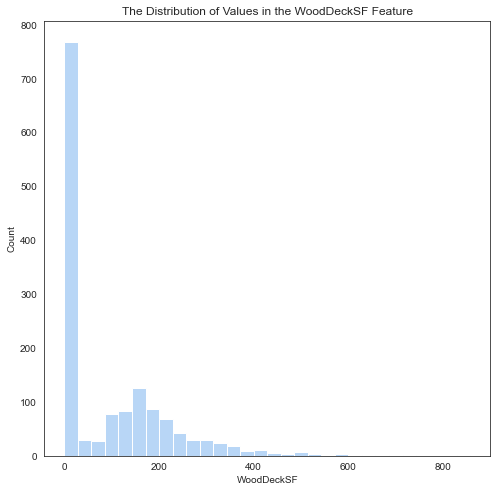

In [140]:
plt.figure(figsize=(8,8))
sns.histplot(df, x="WoodDeckSF", bins=30)
plt.title("The Distribution of Values in the WoodDeckSF Feature");

### 1.5: We are trying to predict the sales price (a continuous variable) of houses in the testing dataset. What does its distribution look like?

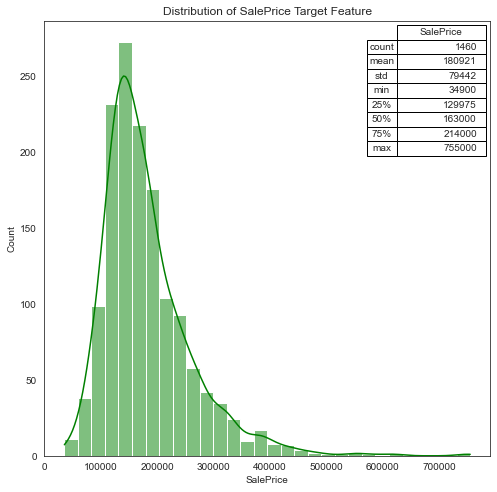

In [141]:
summary = df[['SalePrice']].describe().astype('int32')

sns.set_palette(sns.color_palette("pastel"))
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.title("Distribution of SalePrice Target Feature")
sns.histplot(data = df, x = "SalePrice", bins=30, kde=True, color='green')
plt.table(cellText=summary.values, rowLabels=summary.index, colLabels=summary.columns, cellLoc='right', rowLoc='center', loc='right', bbox=[0.79, 0.69, 0.2, 0.3]);

There is a clear right skew in the Sales Prices of these homes. Beyond that, there seem to be a few outliers at the extreme right. Both of these issues should be addressed. 

## 2.0: Comparing the Colinearity of the Differing Features

### 2.1: Creating a Heat Map

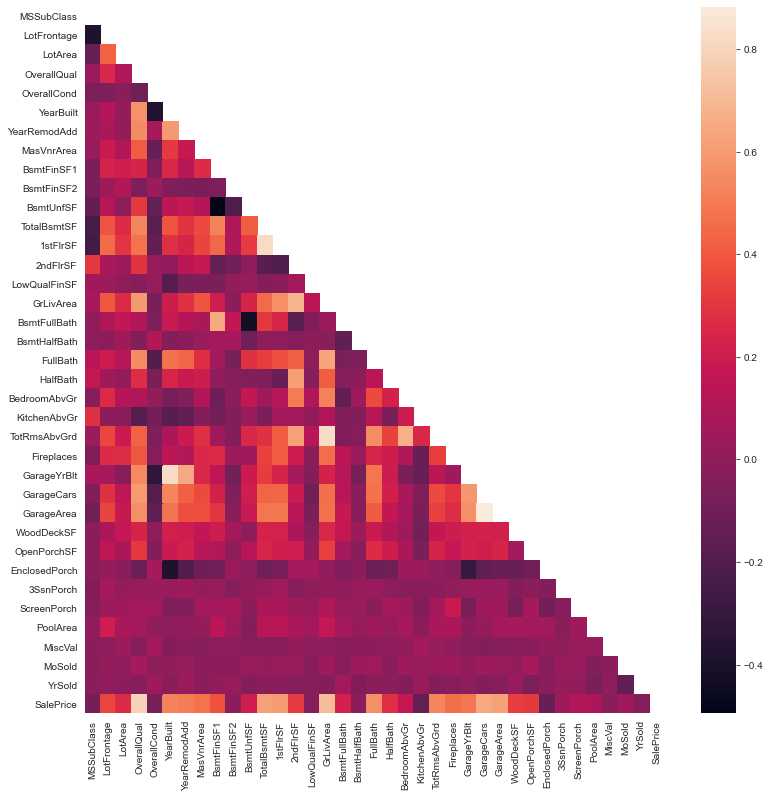

In [142]:
plt.figure(figsize=(13,13))
sns.heatmap(df.drop('Id', axis = 1).corr(), mask = np.triu(df.drop('Id', axis = 1).corr()));

From the looks of it, all of the strong and notable features have a positive connection with the sales price of a house. Below I will gather those relationships are healthy and could not have been made by chance (p-value <= 0.05).

In [143]:
# Create a temporary dataframe with all numeric features and the target feature
temp = pd.concat((df[continuous + discrete], df['SalePrice']), axis = 1).dropna()
# Initialize a dictionary that consists of column_name: (p-value, correlation coefficient)
h1 = {}
for column in temp:
    # For each column in that dataset above, calculate the p-value and correlation coefficient, if p is less than 0.05, and the coefficient is > 0.3, keep and display it
    corr, pval = pearsonr(temp[column], temp['SalePrice'])
    if abs(corr) >= 0.3 and pval <= 0.05:
        h1[column] = (pval, corr)
dict(sorted(h1.items(), key=lambda item: item[1]))

{'SalePrice': (0.0, 0.9999999999999999),
 'OverallQual': (3.1736090867068257e-248, 0.7978806800231069),
 'GrLivArea': (2.7499470443226874e-169, 0.7051535669813256),
 'GarageCars': (5.858719642829807e-134, 0.6470336109231816),
 'GarageArea': (1.0596837938046153e-119, 0.6193296215237221),
 'TotalBsmtSF': (6.771421573023261e-118, 0.6156122368659982),
 '1stFlrSF': (2.9374157361843612e-114, 0.6079691062131667),
 'FullBath': (3.3931133682072934e-96, 0.5666274415430651),
 'TotRmsAbvGrd': (1.6584601808583954e-88, 0.5470673598366215),
 'YearBuilt': (1.4681206422192281e-80, 0.5253935978346056),
 'YearRemodAdd': (4.1716366544857974e-79, 0.5212532703794037),
 'GarageYrBlt': (1.6513295339147198e-73, 0.5047530175703321),
 'MasVnrArea': (2.4545941300343855e-68, 0.4886581549916439),
 'Fireplaces': (2.5618863527185647e-60, 0.46187268853929),
 'BsmtFinSF1': (4.221937183042352e-42, 0.39030052276140936),
 'LotFrontage': (1.5261773976100912e-32, 0.34426977210269727),
 'OpenPorchSF': (2.281935005687525e-32,

The dictionary above represents those features that had a p-value greater than 0.05 and a correlation coefficient greater than 0.3. The latter states that the pair of features            (x and SalePrice) holds a strong relationship, and the former measures whether or not it is statistically significant. Once those hurdles are cleared (and as long as these features do not correlate with each other to a great degree), we can move on. 

### 2.2: Choosing Discrete and Continuous Features

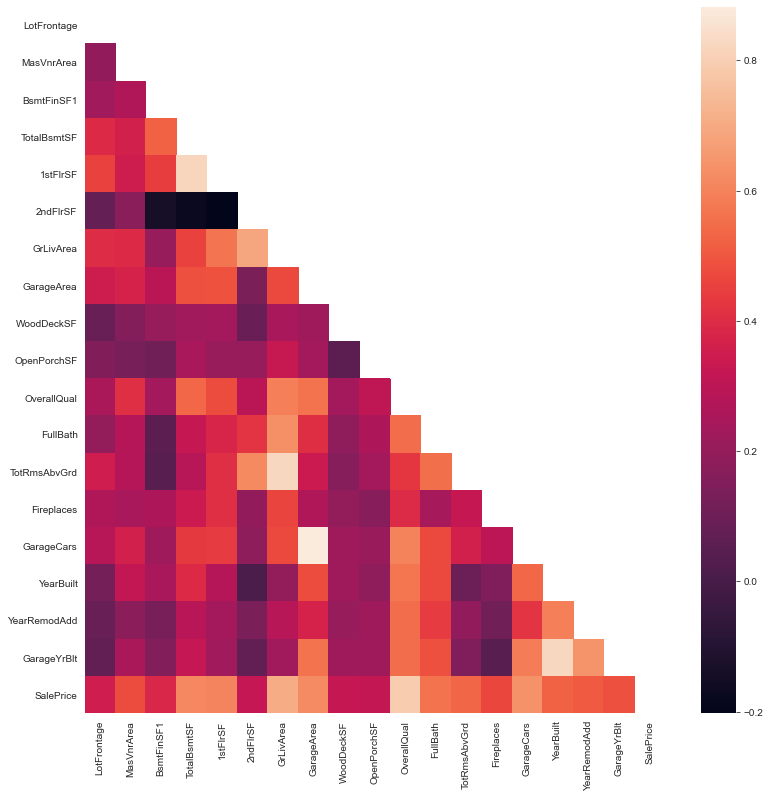

In [144]:
predictive = df.corr()[h1.keys()]
index = df.corr()[h1.keys()].columns
heat = predictive.loc[index]

plt.figure(figsize=(13,13))
sns.heatmap(heat, mask = np.triu(heat));

We see that a couple of the features are correlated with each other such as the number of cars in the garage and its size; with that said their correlation coefficient is not greater than 0.9, meaning that there is still a sizeable amount of information that is independent. Let's take a look a few of these features and visualize how they realte to SalePrie. 

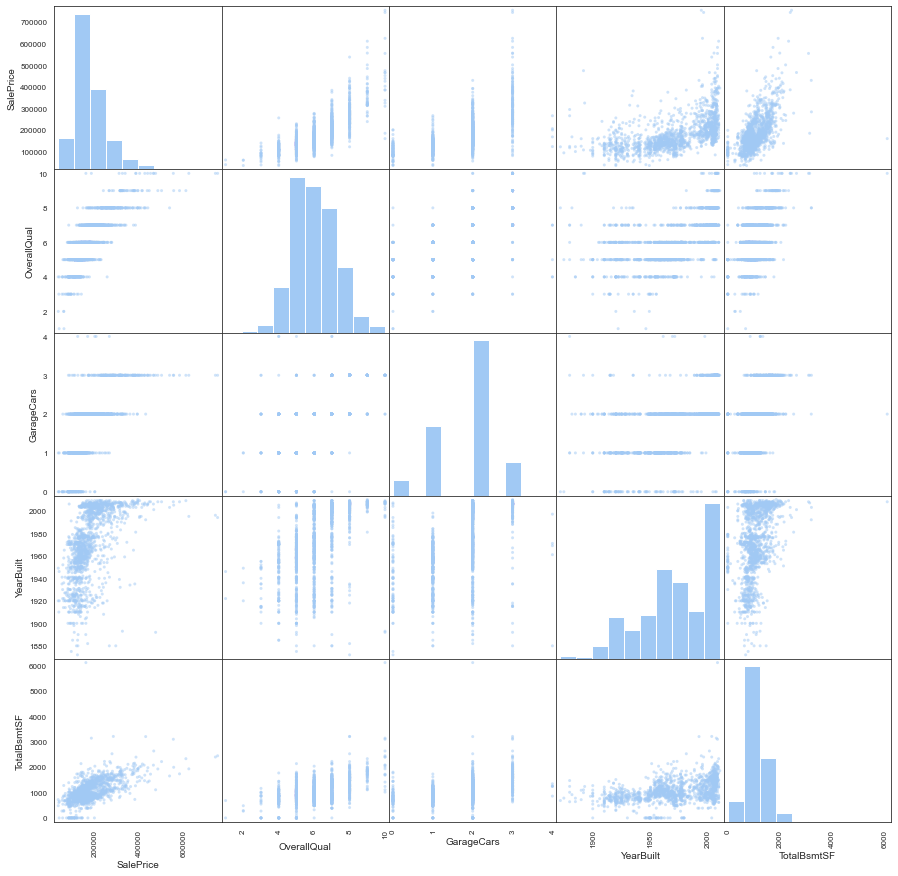

In [145]:
from pandas.plotting import scatter_matrix

attr = ['SalePrice','OverallQual','GarageCars','YearBuilt','TotalBsmtSF']
scatter_matrix(df[attr], figsize=(15,15));


If you look at the top row of the scatter matrix, you can see the positive relationship between SalePrice and the other highly predictive features. They make a certain amount of sense too; improved quality, more luxurious and spacious additions (like basements and garages), and newer buildings would often sell for more than their competitors. 

## 3.0: Feature Engineering

### 3.1: Missing Values

Missing values in this dataset are not random; instead they signal that the observation does not have the optional addon that is being measured. The simple solution here is to create a 'None' label, which holds that information. That said, this only works for categorical features. This becomes a problem for discrete features like 'GarageYrBlt', which has 81 missing values. I chose to fill this by stating that the house had built one in 1900, the earliest year in the dataset. This decision was made because a value needed to be there, 0 would have disrupted the feature, and, assuming a linear relationship with SalePrice, having an ancient garage is the closest we can manage to having none. I'll show the resulting relationship below.

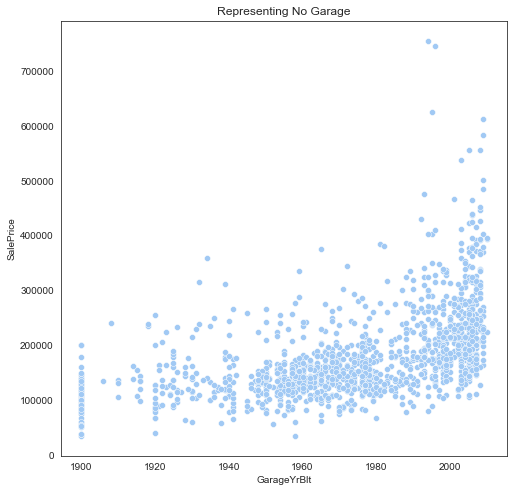

In [146]:
## Filling in the NaN values
df[noms + ords] = df[noms+ords].fillna("None")
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(1900.0)

plt.figure(figsize = (8,8))
sns.scatterplot(data = df, x = "GarageYrBlt", y= "SalePrice")
plt.title("Representing No Garage");

In [147]:
df.isna().sum().sort_values(ascending = False)

LotFrontage     259
MasVnrArea        8
SalePrice         0
Foundation        0
RoofMatl          0
               ... 
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
FireplaceQu       0
Id                0
Length: 81, dtype: int64

This leaves two sources of missing values, LotFrontage and MasVnrArea, which I will simply have filled in by the median value in the numeric pipeline.

### 3.2: Outliers

In [148]:
df['SalePrice'].sort_values(ascending = False).head(10)

691     755000
1182    745000
1169    625000
898     611657
803     582933
1046    556581
440     555000
769     538000
178     501837
798     485000
Name: SalePrice, dtype: int64

The two outliers I found are homes that sold for more than $100,000 more than their nearest competitors, which are more grouped together with the rest of the observations. These values are extreme to the point that they would almost definitely having an outsized influence on the model, so they should be removed. 

In [149]:
df = df.drop(index = [691, 1182])

### 3.3: SalePrice - Skewed Target Feature

As shown in 1.5, the target feature has a right skew; I'll address this by computing the log value of the feature, which should normalize its values. 

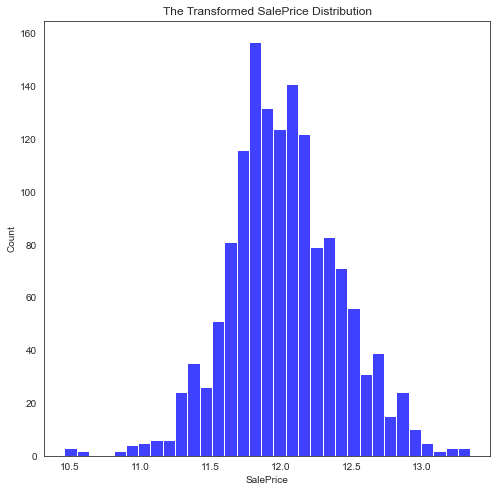

In [150]:
plt.figure(figsize = (8,8))
sns.histplot(df['SalePrice'].transform(np.log), color = 'blue')
plt.title("The Transformed SalePrice Distribution")

df['SalePrice'] = df['SalePrice'].transform(np.log)

### 3.4: Dropping Features

In [151]:
df['Utilities'].value_counts()

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

The Utilities feature would be helpful if it represented something besides homes with all public utilities; seeing how it is right now, it provides no useful information with the exception of its one observation that has no access to public water. Even then, that one record is not sizeable enough to be worthwhile. 

In [152]:
if 'Utilities' in df.columns:
    df = df.drop('Utilities', axis = 1)
if "Utilities" in noms:
    noms.remove('Utilities')

Additionally, the house ID attribute adds nothing of value.

In [153]:
if 'Id' in df.columns:
    df = df.drop('Id', axis = 1)

### 3.5: Numeric Pipeline

In addition to filling in any missing values with the median, the numeric pipeline will standardize the data by using the StandardScaler; this method is more resistant to outliers than MinMaxScaler. 

In [154]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std', StandardScaler())])

### 3.6: Full Pipeline

Categorical features will be split into binary attributes using the OneHotEncoder; ordinal features can be easily ranked, so they can be transformed into numeric values through the OrdinalEncoder. 

In [155]:
from sklearn.compose import ColumnTransformer

# Prepare numeric features by filling in NaN values with the median before standardizing all of them
num_attributes = list(heat.columns)
# Prepare ordinal features by transforming them into numeric values
ordinal_attributes = ords
# Split categorical features into many binary attributes
cat_attributes = noms

full_pipeline = ColumnTransformer([
    ("num", numeric_pipeline, num_attributes),
    ("ord", OrdinalEncoder(), ordinal_attributes),
    ("cats", OneHotEncoder(), cat_attributes),
])

newdf = full_pipeline.fit_transform(df)

In [156]:
Xtrain = pd.DataFrame(newdf.todense())
ytrain = df['SalePrice']